In [ ]:
# 1: INITIAL SETUP AND DATA LOADING
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import os
import zipfile
import json

# Import Natural Language Toolkit (NLTK) for text processing.
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources required for text cleaning.
nltk.download('stopwords')
nltk.download('wordnet')

# For use in Google Colab to upload files.
from google.colab import files

# Upload the dataset archive.
uploaded = files.upload()

# Define the directory
DATA_DIR = '/content/data'

# Extract the contents of the uploaded zip file.
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

# Verify the extracted files by listing them.
print("Extracted files:")
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        print(os.path.join(root, file))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Saving archive.zip to archive.zip
Extracted files:
/content/data/Fake.csv
/content/data/True.csv


In [ ]:
# 2: DATA PREPARATION AND PREPROCESSING
# Imports
import os, re, string
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLTK cleaning utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# If DATA_DIR wasn't defined above, default to Colab's extraction path
DATA_DIR = DATA_DIR if 'DATA_DIR' in globals() else '/content/data'

# Load CSVs
fake_df = pd.read_csv(os.path.join(DATA_DIR, 'Fake.csv'))
true_df = pd.read_csv(os.path.join(DATA_DIR, 'True.csv'))

# Labels
fake_df['label'] = 1
true_df['label'] = 0

# Reuters fix
true_df['text'] = true_df['text'].astype(str).apply(lambda x: x.split(' - ', 1)[-1])

# Build df and unified text field
df = pd.concat([fake_df, true_df], ignore_index=True)\
       .sample(frac=1, random_state=42).reset_index(drop=True)

df['title'] = df['title'].astype(str)
df['text']  = df['text'].astype(str)
df['content'] = df['title'] + ' ' + df['text']

print("\nCombined DataFrame preview:")
print(df[['content', 'label']].head())

# NLTK cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"\d+", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# Remove label-revealing words AFTER cleaning
leak_words = {"fake", "hoax", "false", "real", "truth", "claim"}
def remove_leak_words(text: str) -> str:
    return " ".join([w for w in text.split() if w not in leak_words])

# Produce cleaned text used for modeling
df['clean_content'] = df['content'].apply(clean_text)
df['clean_content'] = df['clean_content'].apply(remove_leak_words)

print("\nCleaned Content preview:")
print(df[['clean_content', 'label']].head())

# Tokenization & padding (LSTM settings)
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = df['label'].to_numpy()

# Keep a copy of raw cleaned text for interpretation tools
X_train, X_test, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X, y, df['clean_content'], test_size=0.2, random_state=42, stratify=y
)

print("\nData successfully split and prepared for modeling.")
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"Texts for interpretation (test): {len(X_test_text)}")



Combined DataFrame preview:
                                             content  label
0  Ben Stein Calls Out 9th Circuit Court: Committ...      1
1  Trump drops Steve Bannon from National Securit...      0
2  Puerto Rico expects U.S. to lift Jones Act shi...      0
3   OOPS: Trump Just Accidentally Confirmed He Le...      1
4  Donald Trump heads for Scotland to reopen a go...      0

Cleaned Content preview:
                                       clean_content  label
0  ben stein call th circuit court committed ‘cou...      1
1  trump drop steve bannon national security coun...      0
2  puerto rico expects u lift jones act shipping ...      0
3  oops trump accidentally confirmed leaked israe...      1
4  donald trump head scotland reopen golf resort ...      0

Data successfully split and prepared for modeling.
X_train shape: (35918, 300) | X_test shape: (8980, 300)
Texts for interpretation (test): 8980


In [ ]:
# 3: LSTM MODEL BUILDING, TRAINING, AND SAVING
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dropout, Dense

# Build the LSTM model architecture.
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 1. Import the Adam optimizer class
from tensorflow.keras.optimizers import Adam

# 2. Instantiate the optimizer with a custom learning rate
custom_optimizer = Adam(learning_rate=0.0001)
# 3. Pass the optimizer instance to the compile method
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])
model.summary()

# Train the model.
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Define the directory to save the model and tokenizer.
SAVED_MODEL_DIR = './saved_model_lstm'
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

# Save the tokenizer to a JSON file.
tokenizer_json = tokenizer.to_json()
with open(os.path.join(SAVED_MODEL_DIR, 'tokenizer.json'), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Save the model's weights.
model.save_weights(os.path.join(SAVED_MODEL_DIR, 'fake_news_lstm.weights.h5'))

print(f"\nModel and tokenizer saved to '{SAVED_MODEL_DIR}' directory:")
print(os.listdir(SAVED_MODEL_DIR))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7717 - loss: 0.4465 - val_accuracy: 0.9695 - val_loss: 0.1030
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9811 - loss: 0.0802 - val_accuracy: 0.9862 - val_loss: 0.0543
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9931 - loss: 0.0349 - val_accuracy: 0.9889 - val_loss: 0.0476
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9958 - loss: 0.0224 - val_accuracy: 0.9878 - val_loss: 0.0418
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9967 - loss: 0.0176 - val_accuracy: 0.9896 - val_loss: 0.0390

Model and tokenizer saved to './saved_model_lstm' directory:
['fake_news_lstm.weights.h5', 'tokenizer.json']



--- Section 4: Evaluating the Model ---
Plotting model training history...


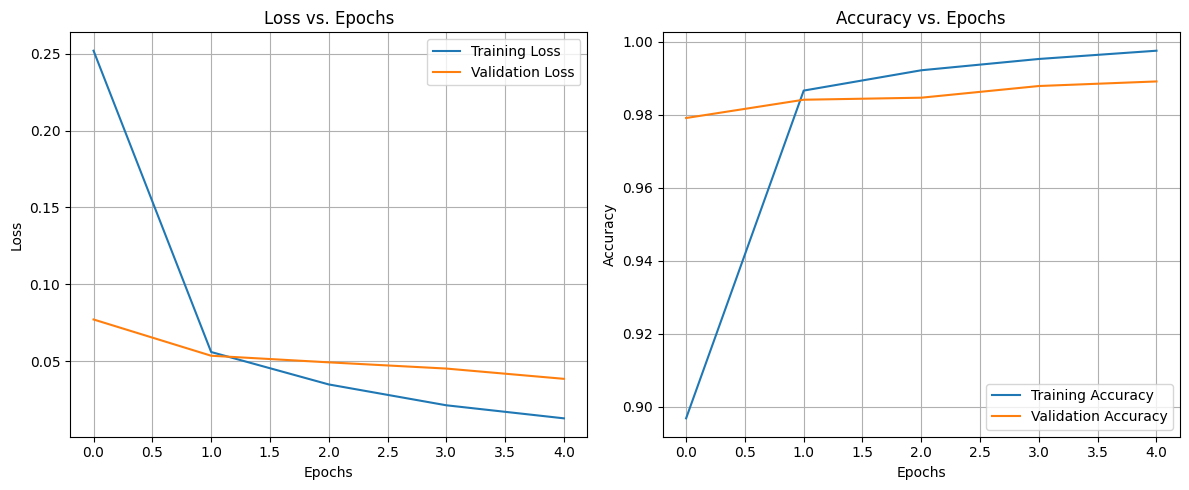


Making predictions on the test set...
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.99      0.99      0.99      4284
    Fake (1)       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:


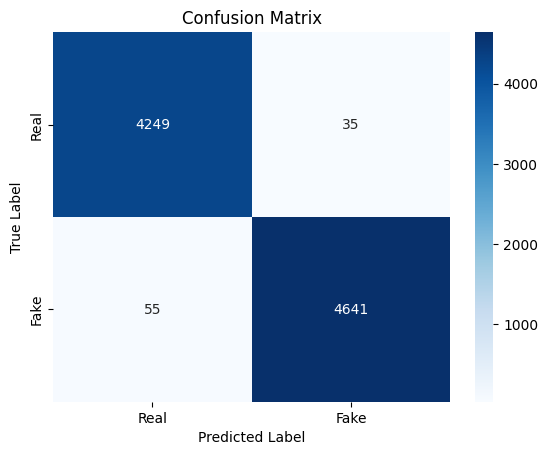

In [ ]:
# 4: MODEL EVALUATION

from sklearn.metrics import classification_report, confusion_matrix

print("\n Evaluating the Model")

# Plot training and validation history to check for overfitting.
print("Plotting model training history...")
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Make predictions on the test set.
print("\nMaking predictions on the test set...")
predicted_probabilities = model.predict(X_test)

# Convert probabilities to binary class predictions using a 0.5 threshold.
binary_predictions = (predicted_probabilities > 0.5).astype(int)

# Display the classification report.
print("\nClassification Report:")
print(classification_report(y_test, binary_predictions, target_names=['Real (0)', 'Fake (1)']))

# Display the confusion matrix.
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, binary_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 5: TESTING ON NEW, UNSEEN EXAMPLES

print("\n 5: Testing on New, Unseen Examples ")

# A list of new articles to test the model's performance on unseen data.
new_articles = [
    # Clearly Fake
    "BREAKING: Scientists confirm lizards from outer space have been running the government for the last 40 years, says unnamed source.",
    # Clearly Real
    "The Federal Reserve announced on Wednesday that it would hold interest rates steady, citing moderate economic growth and a stable labor market.",
    # Nuanced/Clickbait
    "You won't BELIEVE what this one weird trick can do for your skin! Doctors are furious!",
    # Real Political News
    "The prime minister is set to meet with foreign leaders next week to discuss a new trade agreement aimed at reducing tariffs on agricultural products."
]

def predict_fakeness(texts):

    for text in texts:
        # Preprocess the text using the same pipeline as the training data.
        cleaned = clean_text(text)
        cleaned = remove_leak_words(cleaned)

        # Convert to sequence and pad.
        seq = tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

        # Get the prediction score from the model.
        score = model.predict(padded)[0][0]

        # Determine the verdict based on the score.
        verdict = "FAKE" if score > 0.5 else "REAL"

        # Print the results.
        print("-" * 30)
        print(f"Text: '{text[:80]}...'")
        print(f"Predicted Probability (Fake): {score:.3f}")
        print(f"Verdict: {verdict}")

# Run predictions on the new articles.
predict_fakeness(new_articles)



--- Section 5: Testing on New, Unseen Examples ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
------------------------------
Text: 'BREAKING: Scientists confirm lizards from outer space have been running the gove...'
Predicted Probability (Fake): 0.871
Verdict: FAKE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
------------------------------
Text: 'The Federal Reserve announced on Wednesday that it would hold interest rates ste...'
Predicted Probability (Fake): 0.166
Verdict: REAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
------------------------------
Text: 'You won't BELIEVE what this one weird trick can do for your skin! Doctors are fu...'
Predicted Probability (Fake): 0.960
Verdict: FAKE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
------------------------------
Text: 'The prime minister is set to meet with foreign leaders next week to discuss a ne...'
Predicted Probability (Fake): 0.416
Verdict: REAL


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

--- Section 6: Interpreting the Model with LIME ---

Explaining prediction for instance #0:
True Label: Fake
Text: dem rep wife felon caught tape bragging inciting violence trump rally make hilarious number seat democrat take video democratic rep jan schakowsky ill married robert creamer one key figure keefe undercover video showed organizing democrat operative incite trump supporter hoping get commit act violence could caught film thereby helping hillary win electioncreamer convicted felon oversaw checkkiting scheme elaborate employee followed written manual complete detailed instruction float check totaling million dollarsgo mark see robert creamer actionit natural wife disgraced democrat operative convicted felon would asked cnn offer hope future floundering democrat partydemocratic rep jan schakowsky ill said monday belief democrat win seat need retake house re

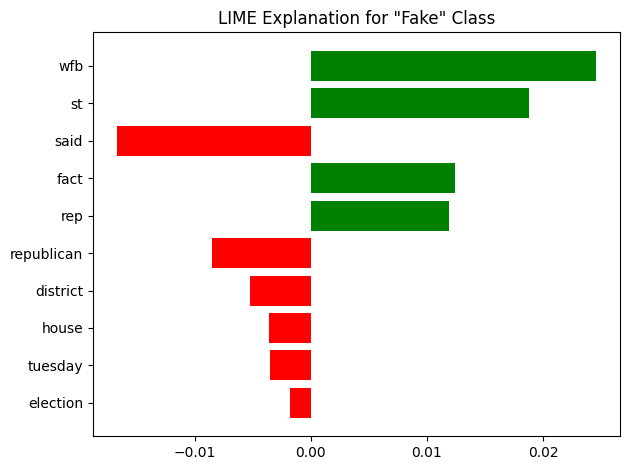

In [ ]:
# 6: MODEL INTERPRETATION WITH LIME

# Install the LIME library quietly.
!pip install lime -q

import lime
from lime.lime_text import LimeTextExplainer

print("\n 6: Interpreting the Model with LIME ")

def lime_predictor(texts):

    # Preprocess the input texts.
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Get predictions from the LSTM model.
    predictions = model.predict(padded_sequences)

    # LIME expects probabilities for each class in the format [P(Real), P(Fake)].
    # Our model outputs P(Fake), so P(Real) is 1 - P(Fake).
    return np.hstack((1 - predictions, predictions))

# Create a LIME text explainer.
explainer = LimeTextExplainer(class_names=['Real', 'Fake'])

# Choose an instance from the test set to explain.
idx_to_explain = 0
text_to_explain = X_test_text.iloc[idx_to_explain]
true_label = y_test[idx_to_explain]
true_label_name = 'Fake' if true_label == 1 else 'Real'

print(f"\nExplaining prediction for instance #{idx_to_explain}:")
print(f"True Label: {true_label_name}")
print(f"Text: {text_to_explain}")

# Generate an explanation for the 'Fake' class (label=1).
explanation = explainer.explain_instance(
    text_to_explain,
    lime_predictor,
    num_features=10,
    labels=(1,)  # We are interested in words that contribute to the 'Fake' prediction.
)

# Display the explanation in the notebook.
print("\nLIME Explanation:")
explanation.show_in_notebook(text=True)

# Visualize the explanation as a plot.
fig = explanation.as_pyplot_figure(label=1)
plt.title('LIME Explanation for "Fake" Class')
plt.tight_layout()
plt.show()


In [ ]:
# 7: GRADIO WEB INTERFACE

# Install the Gradio library quietly.
!pip install gradio -q

import gradio as gr

print("\n 7: Launching Gradio Interface ")

# Define a single prediction function for the Gradio interface.
def predict_fake_news_gradio(text):

    # Preprocess the input text.
    cleaned_text = clean_text(text)
    cleaned_text = remove_leak_words(cleaned_text)

    # Convert to sequence and pad.
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Get the prediction probability.
    probability = model.predict(padded_sequence)[0][0]

    # Determine the verdict.
    verdict = "FAKE" if probability > 0.5 else "REAL"

    # Return a formatted string with the result and confidence.
    return f"Verdict: {verdict} (Confidence: {probability:.2f})"

# Create the Gradio interface.
interface = gr.Interface(
    fn=predict_fake_news_gradio,
    inputs=gr.Textbox(lines=8, placeholder="Enter a news article here..."),
    outputs="text",
    title=" LSTM-Based Fake News Detector",
    description="Paste an article into the text box below. The model will analyze it and classify it as FAKE or REAL news."
)

# Launch the Gradio interface.
interface.launch()